In [18]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

XDIM = 11
COST = 1/XDIM
TRAIN_SLOPE = 1
EVAL_SLOPE = 5
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

# Utils

In [19]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Dataset

In [20]:
def gen_custom_data(N, pos_ranges, neg_ranges):
    """
    pos_ranges: a tuple of tensors of length XDIM.
    (scales tensor, offsets tensor)
    """
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.rand((pos_samples_num, XDIM))*pos_ranges[0] + pos_ranges[1]
    negX = torch.rand((neg_samples_num, XDIM))*neg_ranges[0] + neg_ranges[1]
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def load_credit_default_data():
    torch.manual_seed(0)
    np.random.seed(0)
    url = 'https://raw.githubusercontent.com/ustunb/actionable-recourse/master/examples/paper/data/credit_processed.csv'
    df = pd.read_csv(url)
    df["NoDefaultNextMonth"].replace({0: -1}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    df = df.drop(['Married', 'Single', 'Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59', 'Age_geq_60'], axis = 1)

    scaler = StandardScaler()
    df.loc[:, df.columns != "NoDefaultNextMonth"] = scaler.fit_transform(df.drop("NoDefaultNextMonth", axis=1))

    fraud_df = df.loc[df["NoDefaultNextMonth"] == -1]
    non_fraud_df = df.loc[df["NoDefaultNextMonth"] == 1][:6636]

    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    df = normal_distributed_df.sample(frac=1).reset_index(drop=True)

    Y, X = df.iloc[:, 0].values, df.iloc[:, 1:].values
    return torch.from_numpy(X), torch.from_numpy(Y)

    
def gen_sklearn_data(N, informative_frac=1, shift_range=1, scale_range=1, noise_frac=0.01):
    torch.manual_seed(0)
    np.random.seed(0)
    n_informative = int(informative_frac*XDIM)
    n_redundant = XDIM - n_informative
    shift_arr = shift_range*np.random.randn(XDIM)
    scale_arr = scale_range*np.random.randn(XDIM)
    X, Y = make_classification(n_samples=N, n_features=XDIM, n_informative=n_informative, n_redundant=n_redundant,
                               flip_y=noise_frac, shift=shift_arr, scale=scale_arr, random_state=0)
    Y[Y == 0] = -1
    return torch.from_numpy(X), torch.from_numpy(Y)

def gen_custom_normal_data(N, pos_mean, pos_std, neg_mean, neg_std):
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, XDIM))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, XDIM))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y


# CCP classes

In [21]:
class CCP:
    def __init__(self, x_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, slope):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        slope = np.full(1, slope)
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [22]:
class DELTA():
    
    def __init__(self, x_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der],
                                variables=[self.x])
        
        
    def optimize_X(self, X, w, b, F_DER):
        return self.layer(X, w, b, F_DER)[0]

# Gain & Cost functions

In [23]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r):
    return COST*cp.sum_squares(x-r)

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "score": score}

# Data generation

In [24]:
N = 400
X, Y = load_credit_default_data()
X, Y = X[:3000], Y[:3000]
print(len(X[0]))
assert(len(X[0]) == XDIM)
X, Y, Xval, Yval = split_data(X, Y, 0.5)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)

print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))
# visualize_data(X, Y)

11
percent of positive samples: 49.266666666666666%


# Model

In [25]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, strategic=False, lamb=0):
        torch.manual_seed(0)
        np.random.seed(0)
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.sigmoid = torch.nn.Sigmoid()
        self.strategic = strategic
        self.lamb = lamb
        self.ccp = CCP(x_dim, funcs)
        self.delta = DELTA(x_dim, funcs)

    def forward(self, X, evaluation=False):
        if evaluation:
            XT = self.ccp.optimize_X(X, self.w, self.b, self.eval_slope)
            X_opt = XT
        else:
            XT = self.ccp.optimize_X(X, self.w, self.b, self.train_slope)
            F_DER = self.get_f_ders(XT, self.train_slope)
            X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER) # Xopt should equal to XT but we do it again for the gradients
        
        recouse = self.calc_recourse(X, X_opt)        
        if self.strategic:
            output = self.score(X_opt)
        else:
            output = self.score(X)        
        
        return output, recouse
    
    def optimize_X(self, X, evaluation=False):
        slope = self.eval_slope if evaluation else self.train_slope
        return self.ccp.optimize_X(X, self.w, self.b, slope)
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def evaluate(self, X, Y):
        scores, _ = self.forward(X, evaluation=True)
        Y_pred = torch.sign(scores)
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
        
    def calc_recourse(self, X, X_opt):      
        S = self.score(X)
        is_neg = self.sigmoid(-S)
        
        S = self.score(X_opt)
        is_not_able_to_be_pos = self.sigmoid(-S)
        
        recourse_penalty = is_neg * is_not_able_to_be_pos
        return 1 - torch.mean(recourse_penalty)
    
    def loss(self, Y, Y_pred, recourse):
        if self.lamb > 0:
            return torch.mean(torch.clamp(1 - Y_pred * Y, min=0)) + self.lamb*(1 - recourse)
        else:
            return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
        
    
    def save_model(self, X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, val_recourses, info, path, comment=None):
        if comment is not None:
            path += "_____" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(X.numpy()).to_csv(path + '/X.csv')
        pd.DataFrame(Y.numpy()).to_csv(path + '/Y.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xval.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Yval.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xtest.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Ytest.csv')
        
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        pd.DataFrame(np.array(val_recourses)).to_csv(path + '/val_recourses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, X, Y, Xval, Yval, Xtest, Ytest, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, calc_train_errors=False, comment=None):
        train_dset = TensorDataset(X, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        val_recourses = []
        
        best_val_error = 1
        best_val_recourse = 1
        consecutive_no_improvement = 0
        now = datetime.now()
        path = "C:/Users/sagil/Desktop/nir_project/models/recourse/" + now.strftime("%d-%m-%Y_%H-%M-%S")

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Ybatch in train_loader:
                opt.zero_grad()
                Ybatch_pred, recourse = self.forward(Xbatch)
                l = self.loss(Ybatch, Ybatch_pred, recourse)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                if calc_train_errors:
                    with torch.no_grad():
                        e = self.evaluate(Xbatch, Ybatch)
                        train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | recourse: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), recourse))
                batch += 1
                if callback is not None:
                    callback()

            with torch.no_grad():
                Yval_pred, val_recourse = self.forward(Xval, evaluation=True)
                val_recourse = val_recourse.item()
                val_loss = self.loss(Yval, Yval_pred, val_recourse).item()
                val_losses.append(val_loss)
                val_error = 1-self.evaluate(Xval, Yval)
                val_errors.append(val_error)
                val_recourses.append(val_recourse)
                if val_error < best_val_error:
                    consecutive_no_improvement = 0
                    best_val_error = val_error
                    if self.strategic:
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\nrecourse: {}".format(
                        time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error, val_recourse)
                        self.save_model(X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, val_recourses, info, path, comment)
                        print("model saved!")
                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 6:
                        break
                
            t2 = time.time()
            if verbose:
                print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | recourse: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_recourses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Train

In [26]:
EPOCHS = 10
BATCH_SIZE = 64

x_dim = XDIM

# # non-strategic classification
# print("---------- training non-strategically----------")
# non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)

# fit_res_non_strategic = non_strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
#                                 opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
#                                 batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)


# strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, lamb=10)

# fit_res_strategic = strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
#                                 opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
#                                 batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
#                                 comment="recourse_default")


# lambda_range = torch.logspace(start=0, end=0.3, steps=5)
lambda_range = torch.arange(1, 2.1, 0.2)
print(lambda_range)
for lamb in lambda_range:

    # strategic classification
    print("---------- training strategically----------")
    print("lambda: ", lamb.item())
    strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, lamb=lamb)

    fit_res_strategic = strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
                                    opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)},
                                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
                                    comment="recourse_" + str(lamb.item()))

    

tensor([1.0000, 1.2000, 1.4000, 1.6000, 1.8000, 2.0000])
---------- training strategically----------
lambda:  1.0


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.96414 | recourse: 0.85112
batch 002 / 024 | loss: 1.04343 | recourse: 0.88417
batch 003 / 024 | loss: 1.03257 | recourse: 0.88141
batch 004 / 024 | loss: 1.03814 | recourse: 0.88222
batch 005 / 024 | loss: 1.06752 | recourse: 0.85686
batch 006 / 024 | loss: 1.06647 | recourse: 0.85807
batch 007 / 024 | loss: 1.06560 | recourse: 0.82650
batch 008 / 024 | loss: 1.04905 | recourse: 0.81471
batch 009 / 024 | loss: 1.05260 | recourse: 0.79777
batch 010 / 024 | loss: 1.04467 | recourse: 0.78720
batch 011 / 024 | loss: 1.02656 | recourse: 0.76441
batch 012 / 024 | loss: 1.02892 | recourse: 0.78113
batch 013 / 024 | loss: 1.02379 | recourse: 0.82688


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 014 / 024 | loss: 1.02381 | recourse: 0.74643
batch 015 / 024 | loss: 1.01956 | recourse: 0.77081
batch 016 / 024 | loss: 1.02053 | recourse: 0.74442
batch 017 / 024 | loss: 1.01893 | recourse: 0.75295
batch 018 / 024 | loss: 1.02827 | recourse: 0.72897
batch 019 / 024 | loss: 1.02808 | recourse: 0.74105
batch 020 / 024 | loss: 1.02488 | recourse: 0.71626
batch 021 / 024 | loss: 1.01786 | recourse: 0.77270
batch 022 / 024 | loss: 1.01681 | recourse: 0.73909
batch 023 / 024 | loss: 1.01564 | recourse: 0.71165
batch 024 / 024 | loss: 1.01167 | recourse: 0.77877
model saved!
----- epoch 001 / 010 | time: 297 sec | loss: 0.95764 | recourse: 0.74098 | err: 0.30000
batch 001 / 024 | loss: 0.90833 | recourse: 0.76780
batch 002 / 024 | loss: 1.00189 | recourse: 0.73321
batch 003 / 024 | loss: 0.98960 | recourse: 0.72241
batch 004 / 024 | loss: 0.98092 | recourse: 0.73487
batch 005 / 024 | loss: 0.99380 | recourse: 0.80113
batch 006 / 024 | loss: 1.01821 | recourse: 0.72948
batch 007 / 02

batch 018 / 024 | loss: 0.94570 | recourse: 0.78247
batch 019 / 024 | loss: 0.95077 | recourse: 0.76398
batch 020 / 024 | loss: 0.95234 | recourse: 0.73380
batch 021 / 024 | loss: 0.95343 | recourse: 0.73472
batch 022 / 024 | loss: 0.95165 | recourse: 0.74632
batch 023 / 024 | loss: 0.94967 | recourse: 0.75365
batch 024 / 024 | loss: 0.94839 | recourse: 0.75261
training time: 2762.9179780483246 seconds
---------- training strategically----------
lambda:  1.2


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 0.99391 | recourse: 0.85112
batch 002 / 024 | loss: 1.06990 | recourse: 0.88417
batch 003 / 024 | loss: 1.05866 | recourse: 0.88260
batch 004 / 024 | loss: 1.06502 | recourse: 0.88493
batch 005 / 024 | loss: 1.09727 | recourse: 0.86183
batch 006 / 024 | loss: 1.09696 | recourse: 0.86488
batch 007 / 024 | loss: 1.09885 | recourse: 0.83602
batch 008 / 024 | loss: 1.08402 | recourse: 0.82577
batch 009 / 024 | loss: 1.08868 | recourse: 0.81044
batch 010 / 024 | loss: 1.08152 | recourse: 0.80024
batch 011 / 024 | loss: 1.06471 | recourse: 0.77932
batch 012 / 024 | loss: 1.06757 | recourse: 0.79369
batch 013 / 024 | loss: 1.06197 | recourse: 0.83697
batch 014 / 024 | loss: 1.06329 | recourse: 0.76724
batch 015 / 024 | loss: 1.06003 | recourse: 0.78961
batch 016 / 024 | loss: 1.06120 | recourse: 0.76617
batch 017 / 024 | loss: 1.06119 | recourse: 0.77927
batch 018 / 024 | loss: 1.07161 | recourse: 0.75966
batch 019 / 024 | loss: 1.07225 | recourse: 0.77328
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 016 / 024 | loss: 1.00073 | recourse: 0.77125
batch 017 / 024 | loss: 1.00327 | recourse: 0.75632
batch 018 / 024 | loss: 1.00202 | recourse: 0.77494
batch 019 / 024 | loss: 1.00464 | recourse: 0.75507
batch 020 / 024 | loss: 1.00318 | recourse: 0.75929
batch 021 / 024 | loss: 1.00704 | recourse: 0.76480
batch 022 / 024 | loss: 1.00731 | recourse: 0.80422
batch 023 / 024 | loss: 1.00347 | recourse: 0.75168
batch 024 / 024 | loss: 1.00514 | recourse: 0.74917
----- epoch 002 / 010 | time: 364 sec | loss: 1.00100 | recourse: 0.76636 | err: 0.32667
batch 001 / 024 | loss: 0.97559 | recourse: 0.77297
batch 002 / 024 | loss: 0.96522 | recourse: 0.79732
batch 003 / 024 | loss: 0.97911 | recourse: 0.77883
batch 004 / 024 | loss: 0.99124 | recourse: 0.78565
batch 005 / 024 | loss: 1.02900 | recourse: 0.75216
batch 006 / 024 | loss: 1.02600 | recourse: 0.77997
batch 007 / 024 | loss: 1.03460 | recourse: 0.79728
batch 008 / 024 | loss: 1.01951 | recourse: 0.79468
batch 009 / 024 | loss: 1.0

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 1.02369 | recourse: 0.85112
batch 002 / 024 | loss: 1.09637 | recourse: 0.88417
batch 003 / 024 | loss: 1.08465 | recourse: 0.88365
batch 004 / 024 | loss: 1.09132 | recourse: 0.88693
batch 005 / 024 | loss: 1.12568 | recourse: 0.86537
batch 006 / 024 | loss: 1.12568 | recourse: 0.86981
batch 007 / 024 | loss: 1.12979 | recourse: 0.84356
batch 008 / 024 | loss: 1.11633 | recourse: 0.83467
batch 009 / 024 | loss: 1.12172 | recourse: 0.82169
batch 010 / 024 | loss: 1.11530 | recourse: 0.81225
batch 011 / 024 | loss: 1.09957 | recourse: 0.79311
batch 012 / 024 | loss: 1.10287 | recourse: 0.80577
batch 013 / 024 | loss: 1.09681 | recourse: 0.84632
batch 014 / 024 | loss: 1.09873 | recourse: 0.78618
batch 015 / 024 | loss: 1.09599 | recourse: 0.80631
batch 016 / 024 | loss: 1.09704 | recourse: 0.78695


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 017 / 024 | loss: 1.09801 | recourse: 0.80301
batch 018 / 024 | loss: 1.10924 | recourse: 0.78756
batch 019 / 024 | loss: 1.11059 | recourse: 0.80319
batch 020 / 024 | loss: 1.10628 | recourse: 0.78729
batch 021 / 024 | loss: 1.09944 | recourse: 0.82855
batch 022 / 024 | loss: 1.09925 | recourse: 0.80422
batch 023 / 024 | loss: 1.10017 | recourse: 0.78545
batch 024 / 024 | loss: 1.09411 | recourse: 0.83073
model saved!
----- epoch 001 / 010 | time: 313 sec | loss: 1.03447 | recourse: 0.80394 | err: 0.35333
batch 001 / 024 | loss: 0.99170 | recourse: 0.82183
batch 002 / 024 | loss: 1.06602 | recourse: 0.80008
batch 003 / 024 | loss: 1.06506 | recourse: 0.79094
batch 004 / 024 | loss: 1.05103 | recourse: 0.79519
batch 005 / 024 | loss: 1.06236 | recourse: 0.84161
batch 006 / 024 | loss: 1.08575 | recourse: 0.79383
batch 007 / 024 | loss: 1.07945 | recourse: 0.78869
batch 008 / 024 | loss: 1.06606 | recourse: 0.80481
batch 009 / 024 | loss: 1.05914 | recourse: 0.79655
batch 010 / 02

batch 021 / 024 | loss: 1.04332 | recourse: 0.80913
batch 022 / 024 | loss: 1.04365 | recourse: 0.81605
batch 023 / 024 | loss: 1.04225 | recourse: 0.81499
batch 024 / 024 | loss: 1.03964 | recourse: 0.82293
training time: 2036.325287103653 seconds
---------- training strategically----------
lambda:  1.6


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 1.05346 | recourse: 0.85112
batch 002 / 024 | loss: 1.12285 | recourse: 0.88417
batch 003 / 024 | loss: 1.11054 | recourse: 0.88460
batch 004 / 024 | loss: 1.11753 | recourse: 0.88905
batch 005 / 024 | loss: 1.15409 | recourse: 0.86909
batch 006 / 024 | loss: 1.15446 | recourse: 0.87515
batch 007 / 024 | loss: 1.16070 | recourse: 0.85090
batch 008 / 024 | loss: 1.14843 | recourse: 0.84342
batch 009 / 024 | loss: 1.15446 | recourse: 0.83264
batch 010 / 024 | loss: 1.14862 | recourse: 0.82278
batch 011 / 024 | loss: 1.13488 | recourse: 0.80437
batch 012 / 024 | loss: 1.13823 | recourse: 0.81536
batch 013 / 024 | loss: 1.13153 | recourse: 0.85238
batch 014 / 024 | loss: 1.13373 | recourse: 0.80352
batch 015 / 024 | loss: 1.13122 | recourse: 0.82218
batch 016 / 024 | loss: 1.13214 | recourse: 0.80665
batch 017 / 024 | loss: 1.13400 | recourse: 0.82515
batch 018 / 024 | loss: 1.14533 | recourse: 0.81324
batch 019 / 024 | loss: 1.14711 | recourse: 0.83089
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 292 sec | loss: 1.06027 | recourse: 0.83772 | err: 0.40533
batch 001 / 024 | loss: 1.02327 | recourse: 0.85183
batch 002 / 024 | loss: 1.08530 | recourse: 0.83706
batch 003 / 024 | loss: 1.09511 | recourse: 0.83297
batch 004 / 024 | loss: 1.07606 | recourse: 0.83651
batch 005 / 024 | loss: 1.08805 | recourse: 0.87206
batch 006 / 024 | loss: 1.10859 | recourse: 0.84132
batch 007 / 024 | loss: 1.10335 | recourse: 0.84056
batch 008 / 024 | loss: 1.08826 | recourse: 0.85224
batch 009 / 024 | loss: 1.08618 | recourse: 0.84619
batch 010 / 024 | loss: 1.08117 | recourse: 0.84930
batch 011 / 024 | loss: 1.08819 | recourse: 0.84318
batch 012 / 024 | loss: 1.08708 | recourse: 0.84511
batch 013 / 024 | loss: 1.08494 | recourse: 0.84323
batch 014 / 024 | loss: 1.08159 | recourse: 0.86198
batch 015 / 024 | loss: 1.08310 | recourse: 0.82009
batch 016 / 024 | loss: 1.08088 | recourse: 0.86207
batch 017 / 024 | loss: 1.08055 | recourse: 0.85780
batch 018 / 02

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 1.08324 | recourse: 0.85112
batch 002 / 024 | loss: 1.14932 | recourse: 0.88417
batch 003 / 024 | loss: 1.13630 | recourse: 0.88546
batch 004 / 024 | loss: 1.14341 | recourse: 0.89095
batch 005 / 024 | loss: 1.18185 | recourse: 0.87232
batch 006 / 024 | loss: 1.18252 | recourse: 0.87974
batch 007 / 024 | loss: 1.19098 | recourse: 0.85793
batch 008 / 024 | loss: 1.17973 | recourse: 0.85198
batch 009 / 024 | loss: 1.18680 | recourse: 0.84414
batch 010 / 024 | loss: 1.18156 | recourse: 0.83490
batch 011 / 024 | loss: 1.16722 | recourse: 0.81879
batch 012 / 024 | loss: 1.17071 | recourse: 0.82880
batch 013 / 024 | loss: 1.16362 | recourse: 0.86157
batch 014 / 024 | loss: 1.16534 | recourse: 0.82132
batch 015 / 024 | loss: 1.16302 | recourse: 0.83600
batch 016 / 024 | loss: 1.16364 | recourse: 0.82531
batch 017 / 024 | loss: 1.16588 | recourse: 0.84339
batch 018 / 024 | loss: 1.17738 | recourse: 0.83449
batch 019 / 024 | loss: 1.17932 | recourse: 0.85266
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 331 sec | loss: 1.07112 | recourse: 0.86323 | err: 0.47467
batch 001 / 024 | loss: 1.04475 | recourse: 0.87245
batch 002 / 024 | loss: 1.09338 | recourse: 0.86469
batch 003 / 024 | loss: 1.11228 | recourse: 0.86396
batch 004 / 024 | loss: 1.09209 | recourse: 0.86635
batch 005 / 024 | loss: 1.10500 | recourse: 0.89182
batch 006 / 024 | loss: 1.12459 | recourse: 0.87267
batch 007 / 024 | loss: 1.11971 | recourse: 0.87211
batch 008 / 024 | loss: 1.10204 | recourse: 0.88047
batch 009 / 024 | loss: 1.10243 | recourse: 0.87631
batch 010 / 024 | loss: 1.09757 | recourse: 0.87850
batch 011 / 024 | loss: 1.10635 | recourse: 0.87346
batch 012 / 024 | loss: 1.10658 | recourse: 0.87284
batch 013 / 024 | loss: 1.10260 | recourse: 0.86990
batch 014 / 024 | loss: 1.09915 | recourse: 0.88156
batch 015 / 024 | loss: 1.10214 | recourse: 0.85480
batch 016 / 024 | loss: 1.09903 | recourse: 0.88190
batch 017 / 024 | loss: 1.09865 | recourse: 0.87797
batch 018 / 02

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 024 | loss: 1.11301 | recourse: 0.85112
batch 002 / 024 | loss: 1.17579 | recourse: 0.88417
batch 003 / 024 | loss: 1.16195 | recourse: 0.88623
batch 004 / 024 | loss: 1.16900 | recourse: 0.89268
batch 005 / 024 | loss: 1.20910 | recourse: 0.87516
batch 006 / 024 | loss: 1.20991 | recourse: 0.88347
batch 007 / 024 | loss: 1.22022 | recourse: 0.86344
batch 008 / 024 | loss: 1.20983 | recourse: 0.85871
batch 009 / 024 | loss: 1.21794 | recourse: 0.85334
batch 010 / 024 | loss: 1.21312 | recourse: 0.84300
batch 011 / 024 | loss: 1.19854 | recourse: 0.82761
batch 012 / 024 | loss: 1.20265 | recourse: 0.83754
batch 013 / 024 | loss: 1.19508 | recourse: 0.86856
batch 014 / 024 | loss: 1.19671 | recourse: 0.83302
batch 015 / 024 | loss: 1.19445 | recourse: 0.84608
batch 016 / 024 | loss: 1.19522 | recourse: 0.83579
batch 017 / 024 | loss: 1.19812 | recourse: 0.85494
batch 018 / 024 | loss: 1.20980 | recourse: 0.84803
batch 019 / 024 | loss: 1.21179 | recourse: 0.86539
batch 020 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
----- epoch 001 / 010 | time: 210 sec | loss: 1.09444 | recourse: 0.87597 | err: 0.47600
batch 001 / 024 | loss: 1.06671 | recourse: 0.88385
batch 002 / 024 | loss: 1.11092 | recourse: 0.87783
batch 003 / 024 | loss: 1.13573 | recourse: 0.87846
batch 004 / 024 | loss: 1.11401 | recourse: 0.87947
batch 005 / 024 | loss: 1.12706 | recourse: 0.90184
batch 006 / 024 | loss: 1.14615 | recourse: 0.88718
batch 007 / 024 | loss: 1.14162 | recourse: 0.88761
batch 008 / 024 | loss: 1.12275 | recourse: 0.89564
batch 009 / 024 | loss: 1.12613 | recourse: 0.89223
batch 010 / 024 | loss: 1.12201 | recourse: 0.89299
batch 011 / 024 | loss: 1.13209 | recourse: 0.88914
batch 012 / 024 | loss: 1.13277 | recourse: 0.88711
batch 013 / 024 | loss: 1.12899 | recourse: 0.88336
batch 014 / 024 | loss: 1.12580 | recourse: 0.89409
batch 015 / 024 | loss: 1.12969 | recourse: 0.86726
batch 016 / 024 | loss: 1.12740 | recourse: 0.89345
batch 017 / 024 | loss: 1.12652 | recourse: 0.88995
batch 018 / 02

In [30]:
recourses = []
accuracies = []
path = "C:/Users/sagil/Desktop/nir_project/models/recourse/tradeoff_real"

i=0
for root,d_names,f_names in os.walk(path):
    if "val_recourses.csv" in f_names:
        i+=1
        print(i)
        model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, lamb=lamb)
        model.load_model(root + '/model.pt')
        model.eval_slope = 5
        _, recourse = model.forward(Xval, evaluation=True)
        recourses.append(recourse.item())
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)
        
print(recourses)
print(accuracies)
recourses.reverse()
accuracies.reverse()

1


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

2


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

3


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

4


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

5


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

6


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

7


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

8


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

9


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

10


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

11


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

12


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

13


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

14


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

15


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

16


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

17


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

18


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

19


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

20


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

21


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

22


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

23


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

24


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

25


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

26


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

27


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

28


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

29


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

30


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

31


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

32


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

33


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

34


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

35


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

36


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

[0.6100053252898746, 0.6100403582096388, 0.6096166723081278, 0.6096721093843332, 0.609742967148186, 0.6099460869366136, 0.6097336385072465, 0.6098815254784369, 0.6100714435122923, 0.6103188285019621, 0.6106330323804614, 0.6106647482509564, 0.6112849301807549, 0.6116020582503164, 0.6115572174032127, 0.6128184146797676, 0.612184659513652, 0.612516379124081, 0.6154045407950416, 0.61779350084563, 0.6194041178945027, 0.6233122298719123, 0.6264477051803762, 0.6361254239888203, 0.6484925114334964, 0.681242878247643, 0.6583900411570889, 0.8681866485419303, 0.9349418354977826, 0.9534271142841574, 0.9999995154878201, 0.6921038931303289, 0.764733395827215, 0.8370735206066114, 0.8926386351476836, 0.9193937760151104]
[0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.6946666666666668, 0.694

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


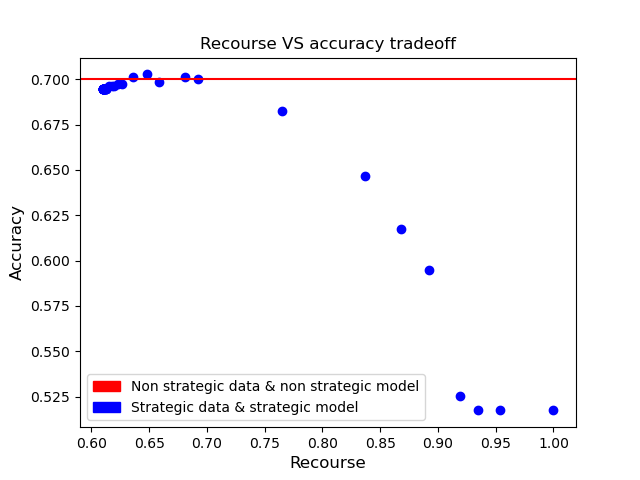

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [31]:
fig = plt.figure()

plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.title('Recourse VS accuracy tradeoff')
plt.xlabel('Recourse')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.scatter(recourses, accuracies, color='b')
plt.axhline(y=0.7, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

# Test results

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.12
0.93
0.12


<IPython.core.display.Javascript object>


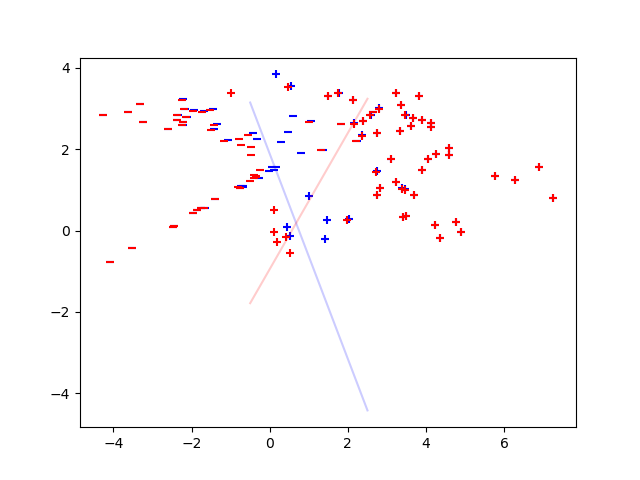

In [158]:
Xval_opt = non_strategic_model.optimize_X(Xval, evaluation=True)
print(non_strategic_model.evaluate(Xval, Yval))
print(strategic_model.evaluate(Xval, Yval))
print(non_strategic_model.evaluate(Xval_opt, Yval))
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, strategic_model.w, strategic_model.b)

